# Gemma-2b-orpo

In this notebook, I show some examples of using this small model,
building a simple Chat and RAG pipeline with the [Haystack LLM framework](https://github.com/deepset-ai/haystack).

In [ ]:
! pip install haystack-ai accelerate transformers

## Chat with Gemma-2b-orpo (travel assistant) 🛩

In [12]:
import torch

In [20]:
from haystack.components.generators.chat import HuggingFaceLocalChatGenerator
from haystack.dataclasses import ChatMessage

generator = HuggingFaceLocalChatGenerator(
    model="anakin87/gemma-2b-orpo",
    generation_kwargs={"max_new_tokens": 350},
    huggingface_pipeline_kwargs={"torch_dtype":torch.bfloat16, "device_map":"auto"})

generator.warm_up()

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
messages = []

while True:
  msg = input("Enter your message or Q to exit\n🧑 ")
  if msg=="Q":
    break
  messages.append(ChatMessage.from_user(msg))
  response = generator.run(messages=messages)
  assistant_resp = response['replies'][0]
  print("🤖 "+assistant_resp.content)
  messages.append(assistant_resp)

Enter your message or Q to exit
🧑  can you help me planning a trip?


🤖 Of course! I'd be happy to help you plan a trip. To get started, could you tell me a bit more about your trip goals, travel style, and preferred travel dates? Additionally, what are your ideal travel destinations and budget range? Once I have a better understanding of your needs and preferences, I can provide more specific and tailored recommendations.



Enter your message or Q to exit
🧑  I would like to take an cheap on-the-road trip to France. do you have any suggestions?


🤖 France is a beautiful country with a rich history and culture, and it offers a variety of road trip options at different price points. Here are some suggestions for a budget-friendly road trip in France:

1. Begin in Paris and drive to the Normandy region to visit the beaches where the Allied troops landed during World War II. This area is known for its beautiful beaches and historic sites, such as the American Cemetery.
2. Continue to the Loire Valley, where you can explore the châteaux (manor houses) and vineyards of the region. Be sure to visit Château de Chenonceau, Château d'Amboise, and Château de Villandry.
3. Drive to the south of France and stop at the medieval town of Carcassonne, which is surrounded by walls and towers.
4. Continue to the Provence region, where you can enjoy the beautiful lavender fields in late summer.
5. Drive to the Côte d'Azur (French Riviera) and spend some time in Nice, a beautiful city with a lovely promenade and a rich cultural scene.
6. Return to 

Enter your message or Q to exit
🧑  nice. can you provide me with a list of things I should take with me to France for the trip?


🤖 Of course! Here is a list of things you should take with you to France for your trip:

1. Passport and Visa: Make sure you have a valid passport and a visa to enter France. You can obtain a visa online before your trip, which is usually faster and cheaper than obtaining one upon arrival.

2. Euros: You will need to have cash in euros to pay for things like food, drinks, and souvenirs. ATMs are widely available in France, and you can use your debit card to withdraw cash. However, it's a good idea to inform your bank about your travel plans to avoid blocked transactions.

3. Travel Insurance: Make sure you have travel insurance that covers your specific needs, including medical expenses, cancellation, and repatriation.

4. Driving License: If you plan to drive in France, you will need to have a valid driving license and possibly additional documents depending on your country of origin.

5. Medicines and Prescriptions: If you have any medical conditions or require prescription medicatio

Enter your message or Q to exit
🧑  Q


## RAG with Gemma-2b-orpo (about Rock music) 🎸

In [7]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [8]:
! pip install wikipedia rich

In [2]:
favourite_bands="""Audioslave
Blink-182
Dire Straits
Evanescence
Green Day
Muse (band)
Nirvana (band)
Sum 41
The Cure
The Smiths""".split("\n")

In [3]:
from IPython.display import Image
from pprint import pprint
import rich
import random

In [4]:
import wikipedia
from haystack.dataclasses import Document

raw_docs=[]

for title in favourite_bands:
    page = wikipedia.page(title=title, auto_suggest=False)
    doc = Document(content=page.content, meta={"title": page.title, "url":page.url})
    raw_docs.append(doc)

### Indexing Pipeline

In [5]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy

In [6]:
document_store = InMemoryDocumentStore()

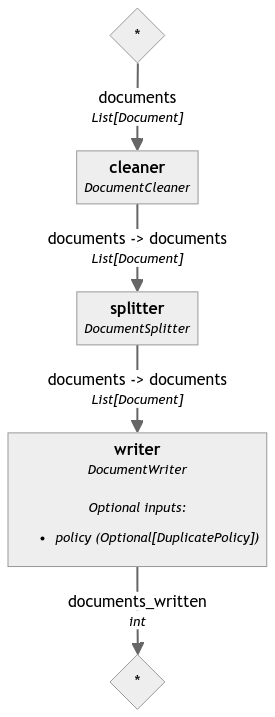

In [7]:
indexing = Pipeline()
indexing.add_component("cleaner", DocumentCleaner())
indexing.add_component("splitter", DocumentSplitter(split_by='sentence', split_length=2))
indexing.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE))

indexing.connect("cleaner", "splitter")
indexing.connect("splitter", "writer")

In [8]:
indexing.run({"cleaner":{"documents":raw_docs}})

{'writer': {'documents_written': 1581}}

In [9]:
document_store.filter_documents()[0].meta

{'title': 'Audioslave',
 'url': 'https://en.wikipedia.org/wiki/Audioslave',
 'source_id': 'e3deff3d39ef107e8b0d69415ea61644b73175086cfbeee03d5f5d6946619fcf'}

### RAG Pipeline

In [10]:
from haystack.components.builders import PromptBuilder

prompt_template = """
<bos><|im_start|> user
Using the information contained in the context, give a comprehensive answer to the question.
If the answer cannot be deduced from the context, do not give an answer.

Context:
  {% for doc in documents %}
  {{ doc.content }}
  {% endfor %};
Question: {{query}}<|im_end|>
<|im_start|>assistant
"""
prompt_builder = PromptBuilder(template=prompt_template)

In [13]:
from haystack.components.generators import HuggingFaceLocalGenerator

generator = HuggingFaceLocalGenerator(
    model="anakin87/gemma-2b-orpo",
    generation_kwargs={"max_new_tokens": 350},
    huggingface_pipeline_kwargs={"torch_dtype":torch.bfloat16, "device_map":"auto"})

generator.warm_up()

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

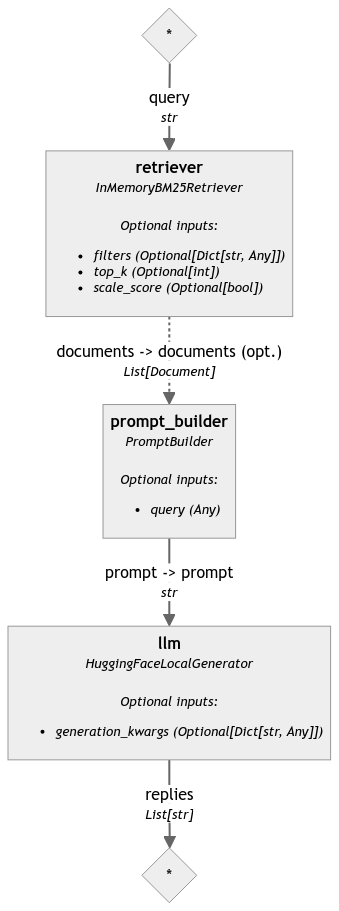

In [14]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

rag = Pipeline()
rag.add_component("retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3))
rag.add_component("prompt_builder", prompt_builder)
rag.add_component("llm", generator)

rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder.prompt", "llm.prompt")

In [15]:
def get_generative_answer(query):

  results = rag.run({
      "retriever": {"query": query},
      "prompt_builder": {"query": query}
    }
  )

  answer = results["llm"]["replies"][0]
  rich.print(answer)

In [17]:
get_generative_answer("Evanescence's \"Bring Me to Life\" features a male vocalist. Who is he, and how does his voice complement Amy Lee's in the song?")

Ranking by BM25...:   0%|          | 0/1563 [00:00<?, ? docs/s]

The male vocalist featured in Evanescence's "Bring Me to Life" is Paul McCoy of 12 Stones. His voice complements 
Amy Lee's in the song by adding a powerful and distinct element to the track. Lee's powerful and emotive vocals are
enhanced by McCoy's smooth and melodic delivery, creating a powerful and emotional song that stands the test of 
time.

In [18]:
nice_questions_to_try="""What was the original name of Sum 41?
What was the title of Nirvana's breakthrough album released in 1991?
Green Day's "American Idiot" is a rock opera. What's the story it tells?
Audioslave was formed by members of two iconic bands. Can you name the bands and discuss the sound of Audioslave in comparison?
Evanescence's "Bring Me to Life" features a male vocalist. Who is he, and how does his voice complement Amy Lee's in the song?
What is Sum 41's debut studio album called?
Who was the lead singer of Audioslave?
When was Nirvana's first studio album, "Bleach," released?
Were the Smiths an influential band?
What is the name of Evanescence's debut album?
Which band was Morrissey the lead singer of before he formed The Smiths?
Dire Straits' hit song "Money for Nothing" features a guest vocal by a famous artist. Who is this artist?
Who played the song "Like a stone"?""".split('\n')

In [ ]:
q=random.choice(nice_questions_to_try)
print(q)
get_generative_answer(q)

This is a simple demo. We can improve the RAG Pipeline using better retrieval techniques: Embedding Retrieval, Hybrid Retrieval...